<a href="https://colab.research.google.com/github/ujjwalbb30/CMSC_678_ASL_image_classification_ML/blob/main/python_notebooks/Part_3_CNN_Mish_ASL_Image_Classification_Ujjwal_PF10610.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classifiying American Sign Language (ASL) images using Covolutional Neural Network (CNN) models**
# **Activation Function : 'mish'**

In this notebook, I will be training 10 different CNN models to classify ASL images. I will mainly use 'mish' activation function in the hidden layers. I will be conducting following experiments in this notebook:

▶ 5 different CNN models (with 1 Convolutional layer, 1 MaxPooling layer and 1 Dropout Layer) will be trained with following kernel sizes:

>(a) (4,4)

>(b) (5,5)

>(c) (6,6)

>(d) (7,7)

>(e) (8,8)

▶ For each kernel size mentioned above, 1 more type of CNN (models having the following characteristics), will be trained:

>(a) 2 Convolutional layers, 2 Maxpooling layers and 2 Dropout layers

▶ In total, 10 models will be trained and following metrics will be calculated for each model along with Confusion matrix:

> (a) Accuracy

> (b) Precision

> (c) Recall

> (d) F1-score

## **Importing required libraries and data**

In [ ]:
# installing split-folders library to split the images dataset folders into training, validation and testing folders
!pip install split-folders

###**Importing required libraries**

In [ ]:
# importing required dependencies

# importing pandas, numpy, random, matplotlib and their required modules
import pandas as pd
import numpy as np
import random
from numpy.random import seed
seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

# importing tensorflow, keras and their required modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam

# importing sklearn and their required modules
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay

# importing other required libraries
import glob
import cv2
import skimage
from skimage.transform import resize
import os
import gc

import splitfolders

###**Mounting the drive and copying the data to allocated machine**

In [ ]:
# mounting the drive to access data files
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# defining the path of data in drive (path to copy the data from)
# defining the path where the data should be copied
drive_path = '/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset'
local_path = '/content'

# copying the data from drive to machine
!cp -av '/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset' '/content'

Streaming output truncated to the last 5000 lines.
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1898.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1898.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1904.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1904.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1890.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1890.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1880.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1880.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1908.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1908.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1888.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1888.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1876.jpg' -> '/content/dataset/asl_alphabet_tr

###**Defining the mish activation function**

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
import tensorflow_addons as tfa
def mish(x):
    return tfa.activations.mish(x)

In [ ]:
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'mish': Activation(mish)})

###**Splitting the images dataset folder into train, validation and test images**
###**creating train, validation and test dataframes of image paths and labels**

In [ ]:
# splitting the folder intro training, validation and test dataset
splitfolders.ratio("/content/dataset/asl_alphabet_train", output="/content/dataset/split_dataset", seed=42, ratio=(.7, .1, .2), group_prefix=None)

Copying files: 87020 files [00:12, 7191.07 files/s]


In [ ]:
# Exploring the new created split dataset folder
dataset_folder_path = '/content/dataset/split_dataset'
for path, directories, files in os.walk(dataset_folder_path):
    print(path,'--> number of files : ', len(files))

/content/dataset/split_dataset --> number of files :  0
/content/dataset/split_dataset/test --> number of files :  0
/content/dataset/split_dataset/test/I --> number of files :  602
/content/dataset/split_dataset/test/B --> number of files :  600
/content/dataset/split_dataset/test/K --> number of files :  600
/content/dataset/split_dataset/test/M --> number of files :  600
/content/dataset/split_dataset/test/A --> number of files :  600
/content/dataset/split_dataset/test/F --> number of files :  600
/content/dataset/split_dataset/test/W --> number of files :  600
/content/dataset/split_dataset/test/Z --> number of files :  600
/content/dataset/split_dataset/test/U --> number of files :  600
/content/dataset/split_dataset/test/J --> number of files :  600
/content/dataset/split_dataset/test/nothing --> number of files :  600
/content/dataset/split_dataset/test/R --> number of files :  600
/content/dataset/split_dataset/test/L --> number of files :  600
/content/dataset/split_dataset/t

In [ ]:
# Preparing train, validation and test dataframes of image paths and labels

# defining the path to train, validation and test images data folders
train_dataset_folder = '/content/dataset/split_dataset/train'
validation_dataset_folder = '/content/dataset/split_dataset/val'
test_dataset_folder = '/content/dataset/split_dataset/test'

# initializing empty lists to store paths and labels of train, validation and test images
train_data = []
val_data = []
test_data = []

# saving train images paths and labels
for folder in os.listdir(train_dataset_folder):
    label_folder = os.path.join(train_dataset_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    train_data += onlyfiles

# saving validation images paths and labels
for folder in os.listdir(validation_dataset_folder):
    label_folder = os.path.join(validation_dataset_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    val_data += onlyfiles

# saving test images paths and labels
for folder in os.listdir(test_dataset_folder):
    label_folder = os.path.join(test_dataset_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    test_data += onlyfiles

# creating dataframes from the lists
train_data_df = pd.DataFrame(train_data)
val_data_df = pd.DataFrame(val_data)
test_data_df = pd.DataFrame(test_data)

# viewing the details of training dataframe
print('training data:\n')
display(train_data_df)
print('\nunique labels:\n',train_data_df['label'].unique())
print('\n number of unique labels:\n',train_data_df['label'].nunique())

# viewing the details of validation dataframe
print('\nvalidation data:\n')
display(val_data_df)
print('\nunique labels:\n',val_data_df['label'].unique())
print('\n number of unique labels:\n',val_data_df['label'].nunique())

# viewing the details of testing dataframe
print('\ntesting data:\n')
display(test_data_df)
print('\nunique labels:\n',test_data_df['label'].unique())
print('\n number of unique labels:\n',test_data_df['label'].nunique())

training data:



,label,path
0,I,/content/dataset/split_dataset/train/I/I2242.jpg
1,I,/content/dataset/split_dataset/train/I/I1159.jpg
2,I,/content/dataset/split_dataset/train/I/I512.jpg
3,I,/content/dataset/split_dataset/train/I/I1000.jpg
4,I,/content/dataset/split_dataset/train/I/I2856.jpg
...,...,...
60909,P,/content/dataset/split_dataset/train/P/P216.jpg
60910,P,/content/dataset/split_dataset/train/P/P2255.jpg
60911,P,/content/dataset/split_dataset/train/P/P569.jpg
60912,P,/content/dataset/split_dataset/train/P/P878.jpg



unique labels:
 ['I' 'B' 'K' 'M' 'A' 'F' 'W' 'Z' 'U' 'J' 'nothing' 'R' 'L' 'G' 'T' 'H' 'Q'
 'X' 'S' 'Y' 'C' 'V' 'N' 'space' 'O' 'del' 'E' 'D' 'P']

 number of unique labels:
 29

validation data:



,label,path
0,I,/content/dataset/split_dataset/val/I/I301.jpg
1,I,/content/dataset/split_dataset/val/I/I2355.jpg
2,I,/content/dataset/split_dataset/val/I/I1761.jpg
3,I,/content/dataset/split_dataset/val/I/I2032.jpg
4,I,/content/dataset/split_dataset/val/I/I696.jpg
...,...,...
8697,P,/content/dataset/split_dataset/val/P/P2932.jpg
8698,P,/content/dataset/split_dataset/val/P/P2612.jpg
8699,P,/content/dataset/split_dataset/val/P/P1073.jpg
8700,P,/content/dataset/split_dataset/val/P/P1388.jpg



unique labels:
 ['I' 'B' 'K' 'M' 'A' 'F' 'W' 'Z' 'U' 'J' 'nothing' 'R' 'L' 'G' 'T' 'H' 'Q'
 'X' 'S' 'Y' 'C' 'V' 'N' 'space' 'O' 'del' 'E' 'D' 'P']

 number of unique labels:
 29

testing data:



,label,path
0,I,/content/dataset/split_dataset/test/I/I1856.jpg
1,I,/content/dataset/split_dataset/test/I/I525.jpg
2,I,/content/dataset/split_dataset/test/I/I636.jpg
3,I,/content/dataset/split_dataset/test/I/I1972.jpg
4,I,/content/dataset/split_dataset/test/I/I423.jpg
...,...,...
17399,P,/content/dataset/split_dataset/test/P/P1895.jpg
17400,P,/content/dataset/split_dataset/test/P/P822.jpg
17401,P,/content/dataset/split_dataset/test/P/P656.jpg
17402,P,/content/dataset/split_dataset/test/P/P42.jpg



unique labels:
 ['I' 'B' 'K' 'M' 'A' 'F' 'W' 'Z' 'U' 'J' 'nothing' 'R' 'L' 'G' 'T' 'H' 'Q'
 'X' 'S' 'Y' 'C' 'V' 'N' 'space' 'O' 'del' 'E' 'D' 'P']

 number of unique labels:
 29


In [ ]:
# viewing random images of each label from train dataframe

unique_asl_signs = train_data_df['label'].unique().tolist()
images = []

for sign in unique_asl_signs:
    rows = train_data_df[train_data_df['label']==sign]['path']
    random_pick = random.randint(a=0, b=len(rows))
    filepath = rows.iloc[random_pick]
    img = mpimg.imread(filepath)
    plt.figure()
    plt.title(sign)
    plt.imshow(img)

In [ ]:
# viewing number of images in train dataset, validation dataset and test dataset
print(f'training data size: {len(train_data_df)}')
print(f'validation data size: {len(val_data_df)}')
print(f'testing data size: {len(test_data_df)}')

training data size: 60914
validation data size: 8702
testing data size: 17404


###**Creating image data generators for train, validation and test image dataset to feed the images to training models in batches**

In [ ]:
# creating image data generators

# defining image dimensions, batch size, target size of image, target dimensions and number of labels
img_dim = 64
batch_size = 64
target_size = (img_dim, img_dim)
target_dims = (img_dim, img_dim, 3)
num_classes = len(train_data_df['label'].unique())

# images are normalized, but not augmented

# train image generator
train_datagen = ImageDataGenerator(rescale = 1/255.0)
train_generator = train_datagen.flow_from_dataframe(dataframe=train_data_df,x_col='path', y_col='label', target_size=(img_dim, img_dim),class_mode='categorical', batch_size=batch_size, shuffle=False)

# validation image generator
validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(dataframe=val_data_df, x_col='path', y_col='label', target_size=(img_dim, img_dim), class_mode='categorical', batch_size=batch_size, shuffle=False)

# testing image generator
test_datagen = ImageDataGenerator(rescale = 1/255.0)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_data_df, x_col='path', y_col='label', target_size=(img_dim, img_dim), class_mode='categorical', batch_size=batch_size, shuffle=False)


Found 60914 validated image filenames belonging to 29 classes.
Found 8702 validated image filenames belonging to 29 classes.
Found 17404 validated image filenames belonging to 29 classes.


## **CNN Models with 1 Convolutional layer, 1 Maxpooling layer and 1 Dropout layer**

#### **Kernel size - (5,5)**

In [ ]:
# defining the model
model_1_1l = Sequential()

model_1_1l.add(Conv2D(32, kernel_size=(5,5), input_shape=target_dims))
model_1_1l.add(Activation('relu'))
model_1_1l.add(MaxPooling2D((2, 2)))
model_1_1l.add(Dropout(0.5))

model_1_1l.add(Flatten())
model_1_1l.add(Dropout(0.5))

model_1_1l.add(Dense(128, activation='mish'))

model_1_1l.add(Dense(num_classes, activation='softmax'))

model_1_1l.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 activation_4 (Activation)   (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 28800)             0         
                                                                 
 dropout_5 (Dropout)         (None, 28800)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_1_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_1_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 96s 100ms/step - loss: 2.9762 - accuracy: 0.1805 - val_loss: 2.1697 - val_accuracy: 0.3643
Epoch 2/10
952/952 [==============================] - 94s 98ms/step - loss: 1.8521 - accuracy: 0.4330 - val_loss: 1.1547 - val_accuracy: 0.6698
Epoch 3/10
952/952 [==============================] - 91s 96ms/step - loss: 1.1807 - accuracy: 0.6216 - val_loss: 0.8399 - val_accuracy: 0.7260
Epoch 4/10
952/952 [==============================] - 88s 93ms/step - loss: 0.7946 - accuracy: 0.7385 - val_loss: 0.5485 - val_accuracy: 0.8248
Epoch 5/10
952/952 [==============================] - 89s 94ms/step - loss: 0.5951 - accuracy: 0.8016 - val_loss: 0.4794 - val_accuracy: 0.8349
Epoch 6/10
952/952 [==============================] - 89s 93ms/step - loss: 0.4508 - accuracy: 0.8441 - val_loss: 0.3148 - val_accuracy: 0.8911
Epoch 7/10
952/952 [==============================] - 102s 107ms/step - loss: 0.3600 - accuracy: 0.8745 - val_loss: 0.2169 - val_accura

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_1_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,2.976216,0.180451,2.169667,0.364284
1,1.852133,0.432971,1.154694,0.669846
2,1.180735,0.621598,0.839890,0.726040
3,0.794628,0.738451,0.548490,0.824753
4,0.595136,0.801556,0.479369,0.834866
5,0.450769,0.844141,0.314824,0.891060
6,0.359957,0.874462,0.216897,0.935762
7,0.295427,0.897741,0.182910,0.942427
8,0.255700,0.910497,0.117747,0.962422
9,0.233288,0.919050,0.131580,0.952540


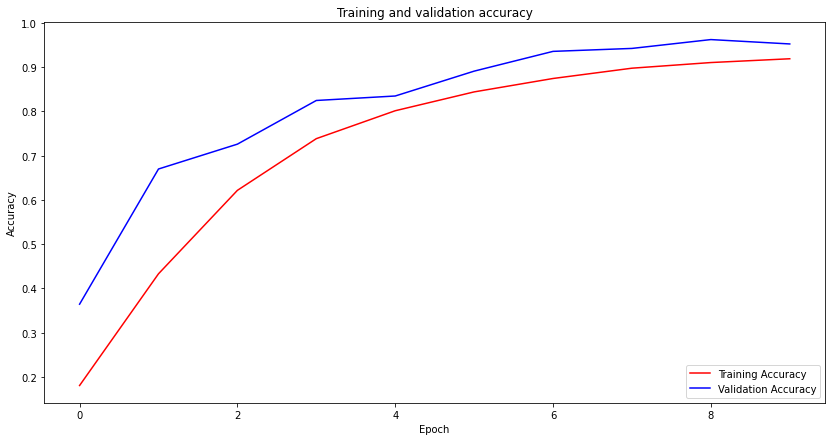

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_1_1l.history.history['accuracy']
val_acc= model_1_1l.history.history['val_accuracy']
loss= model_1_1l.history.history['loss']
val_loss= model_1_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

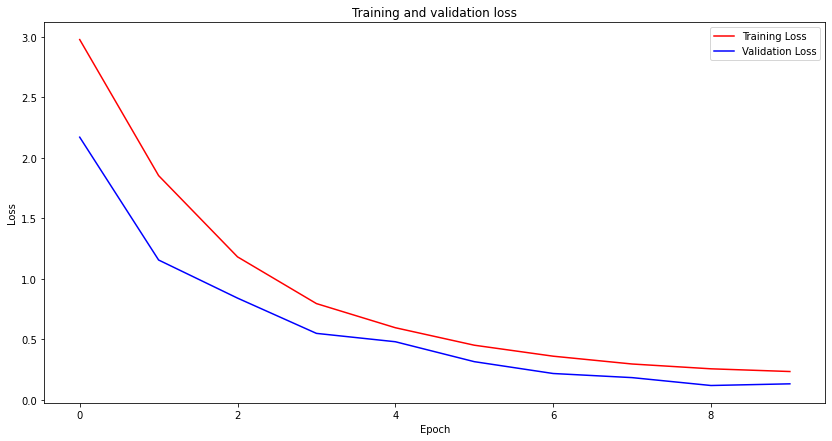

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_1_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 22s 81ms/step - loss: 0.1311 - accuracy: 0.9546
loss : 0.13105720281600952 acc : 0.954608142375946


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_1_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 22s 79ms/step
              precision    recall  f1-score   support

           A       0.98      0.98      0.98       600
           B       0.91      1.00      0.95       600
           C       1.00      1.00      1.00       600
           D       0.96      1.00      0.98       600
           E       1.00      0.87      0.93       600
           F       1.00      1.00      1.00       600
           G       0.99      0.99      0.99       600
           H       0.99      1.00      0.99       600
           I       1.00      0.99      0.99       602
           J       1.00      0.99      1.00       600
           K       0.98      0.99      0.99       600
           L       0.99      1.00      0.99       600
           M       0.83      1.00      0.90       600
           N       1.00      0.84      0.91       602
           O       1.00      0.90      0.94       600
           P       1.00      0.91      0.95       600
           Q       0.92 

<Figure size 3600x3600 with 0 Axes>

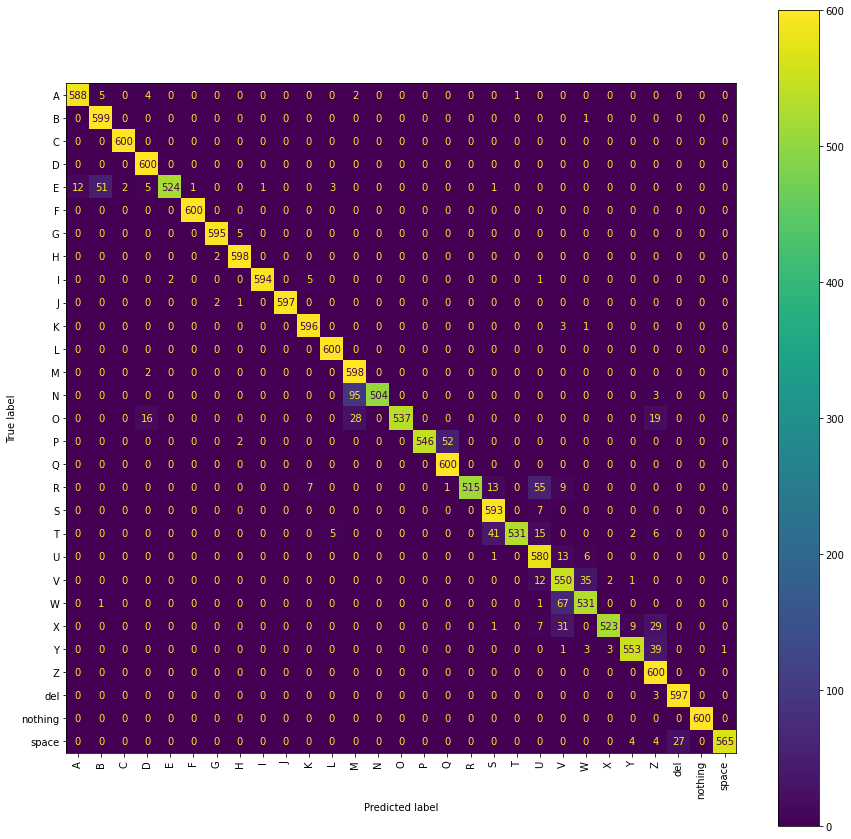

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (7,7)**

In [ ]:
# defining the model
model_2_1l = Sequential()

model_2_1l.add(Conv2D(32, kernel_size=(7,7), input_shape=target_dims))
model_2_1l.add(Activation('relu'))
model_2_1l.add(MaxPooling2D((2, 2)))
model_2_1l.add(Dropout(0.5))

model_2_1l.add(Flatten())
model_2_1l.add(Dropout(0.5))

model_2_1l.add(Dense(128, activation='mish'))

model_2_1l.add(Dense(num_classes, activation='softmax'))

model_2_1l.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 58, 58, 32)        4736      
                                                                 
 activation_5 (Activation)   (None, 58, 58, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 29, 29, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 26912)             0         
                                                                 
 dropout_7 (Dropout)         (None, 26912)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_2_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_2_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 117s 122ms/step - loss: 3.1274 - accuracy: 0.1167 - val_loss: 2.2736 - val_accuracy: 0.3636
Epoch 2/10
952/952 [==============================] - 129s 136ms/step - loss: 1.9283 - accuracy: 0.4180 - val_loss: 1.2774 - val_accuracy: 0.6000
Epoch 3/10
952/952 [==============================] - 107s 112ms/step - loss: 1.3236 - accuracy: 0.5798 - val_loss: 0.8601 - val_accuracy: 0.7440
Epoch 4/10
952/952 [==============================] - 105s 110ms/step - loss: 0.9871 - accuracy: 0.6804 - val_loss: 0.6777 - val_accuracy: 0.7850
Epoch 5/10
952/952 [==============================] - 91s 95ms/step - loss: 0.7844 - accuracy: 0.7394 - val_loss: 0.5017 - val_accuracy: 0.8404
Epoch 6/10
952/952 [==============================] - 87s 91ms/step - loss: 0.6647 - accuracy: 0.7754 - val_loss: 0.3788 - val_accuracy: 0.8867
Epoch 7/10
952/952 [==============================] - 87s 92ms/step - loss: 0.5700 - accuracy: 0.8091 - val_loss: 0.3256 - val_a

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_2_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.127380,0.116689,2.273633,0.363595
1,1.928280,0.417999,1.277431,0.599977
2,1.323595,0.579801,0.860123,0.743967
3,0.987135,0.680435,0.677743,0.784992
4,0.784413,0.739354,0.501680,0.840382
5,0.664669,0.775355,0.378808,0.886693
6,0.570000,0.809108,0.325577,0.894622
7,0.480201,0.836277,0.249660,0.922661
8,0.430117,0.853318,0.224696,0.929212
9,0.409230,0.860377,0.176206,0.952884


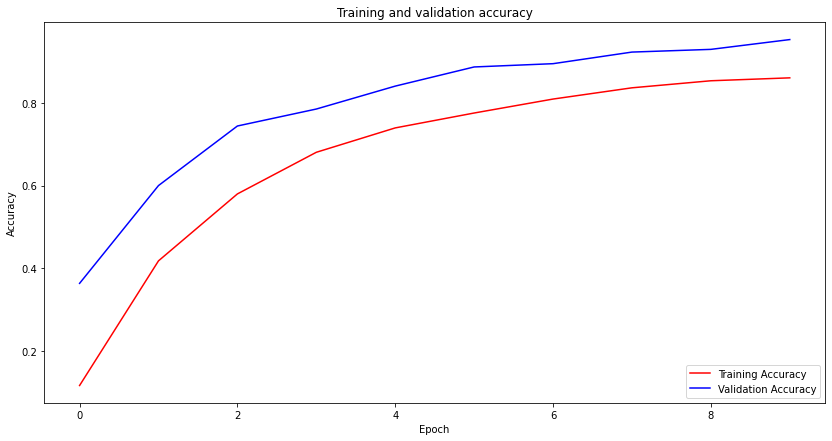

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_2_1l.history.history['accuracy']
val_acc= model_2_1l.history.history['val_accuracy']
loss= model_2_1l.history.history['loss']
val_loss= model_2_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

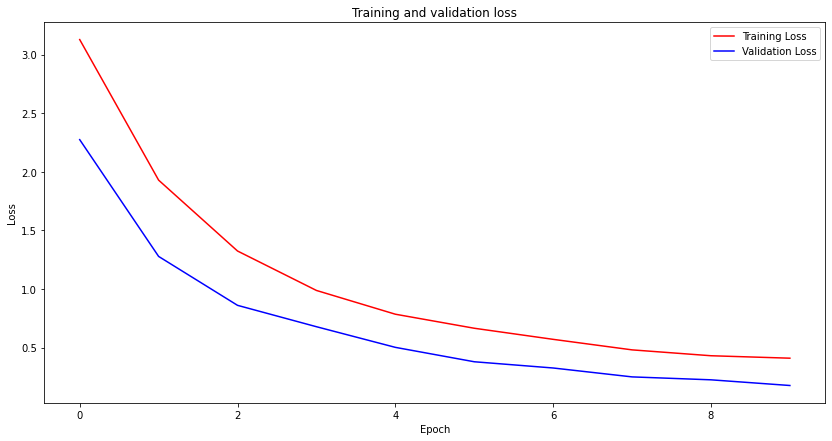

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_2_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 69ms/step - loss: 0.1753 - accuracy: 0.9533
loss : 0.1753050535917282 acc : 0.9532865881919861


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_2_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 69ms/step
              precision    recall  f1-score   support

           A       0.97      0.96      0.97       600
           B       0.97      0.98      0.98       600
           C       1.00      1.00      1.00       600
           D       0.99      0.98      0.98       600
           E       0.95      0.93      0.94       600
           F       0.97      0.99      0.98       600
           G       0.99      0.97      0.98       600
           H       0.96      1.00      0.98       600
           I       0.99      0.99      0.99       602
           J       0.99      0.99      0.99       600
           K       0.96      1.00      0.98       600
           L       0.99      1.00      1.00       600
           M       0.96      0.97      0.97       600
           N       0.97      0.97      0.97       602
           O       0.99      0.95      0.97       600
           P       1.00      0.89      0.94       600
           Q       0.88 

<Figure size 3600x3600 with 0 Axes>

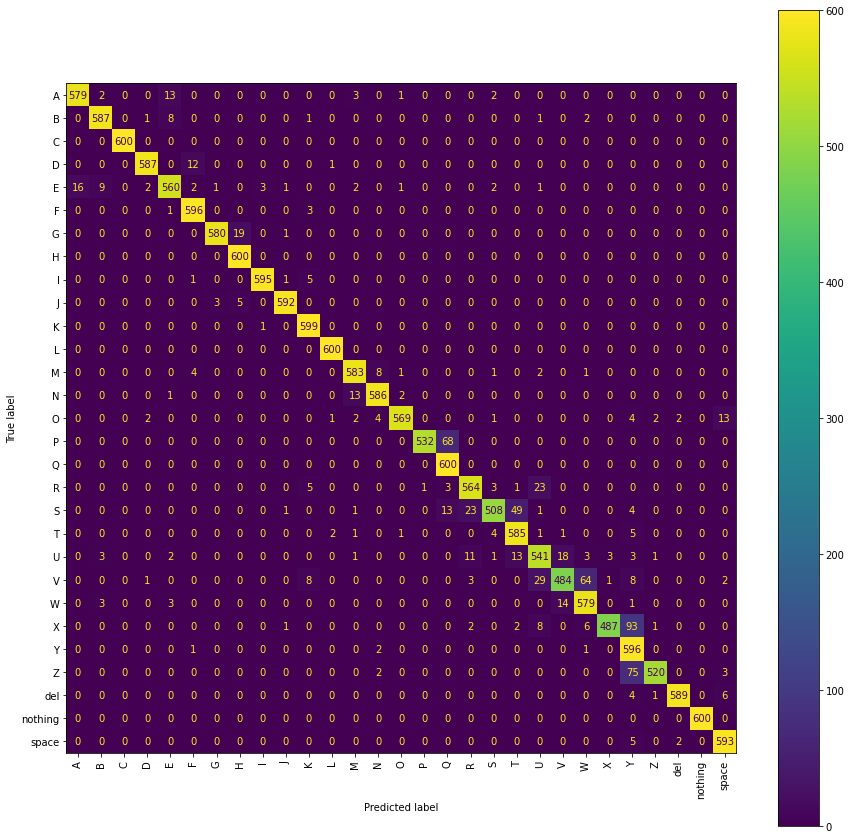

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (4,4)**

In [ ]:
# defining the model
model_3_1l = Sequential()

model_3_1l.add(Conv2D(32, kernel_size=(4,4), input_shape=target_dims))
model_3_1l.add(Activation('relu'))
model_3_1l.add(MaxPooling2D((2, 2)))
model_3_1l.add(Dropout(0.5))

model_3_1l.add(Flatten())
model_3_1l.add(Dropout(0.5))

model_3_1l.add(Dense(128, activation='mish'))

model_3_1l.add(Dense(num_classes, activation='softmax'))

model_3_1l.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        1568      
                                                                 
 activation_6 (Activation)   (None, 61, 61, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 flatten_4 (Flatten)         (None, 28800)             0         
                                                                 
 dropout_9 (Dropout)         (None, 28800)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_3_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_3_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 85s 89ms/step - loss: 2.9210 - accuracy: 0.1905 - val_loss: 1.8146 - val_accuracy: 0.4866
Epoch 2/10
952/952 [==============================] - 85s 89ms/step - loss: 1.5237 - accuracy: 0.5260 - val_loss: 1.0171 - val_accuracy: 0.6898
Epoch 3/10
952/952 [==============================] - 84s 89ms/step - loss: 0.9405 - accuracy: 0.6880 - val_loss: 0.6962 - val_accuracy: 0.7697
Epoch 4/10
952/952 [==============================] - 85s 90ms/step - loss: 0.6535 - accuracy: 0.7779 - val_loss: 0.4247 - val_accuracy: 0.8636
Epoch 5/10
952/952 [==============================] - 85s 89ms/step - loss: 0.4891 - accuracy: 0.8299 - val_loss: 0.3437 - val_accuracy: 0.8862
Epoch 6/10
952/952 [==============================] - 85s 89ms/step - loss: 0.3771 - accuracy: 0.8699 - val_loss: 0.2425 - val_accuracy: 0.9155
Epoch 7/10
952/952 [==============================] - 85s 89ms/step - loss: 0.3310 - accuracy: 0.8828 - val_loss: 0.2357 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_3_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,2.920954,0.190498,1.814625,0.486555
1,1.523726,0.526037,1.017102,0.689841
2,0.940470,0.687986,0.696228,0.769708
3,0.653504,0.777884,0.424665,0.863595
4,0.489113,0.829908,0.343691,0.886233
5,0.377126,0.869948,0.242542,0.915537
6,0.331011,0.882769,0.235669,0.918295
7,0.261633,0.909561,0.134743,0.962308
8,0.263328,0.907181,0.138340,0.959435
9,0.219791,0.921873,0.107185,0.972305


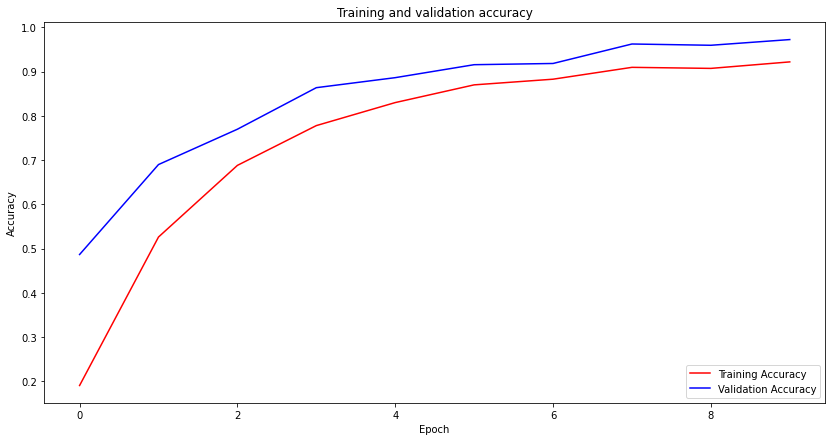

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_3_1l.history.history['accuracy']
val_acc= model_3_1l.history.history['val_accuracy']
loss= model_3_1l.history.history['loss']
val_loss= model_3_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

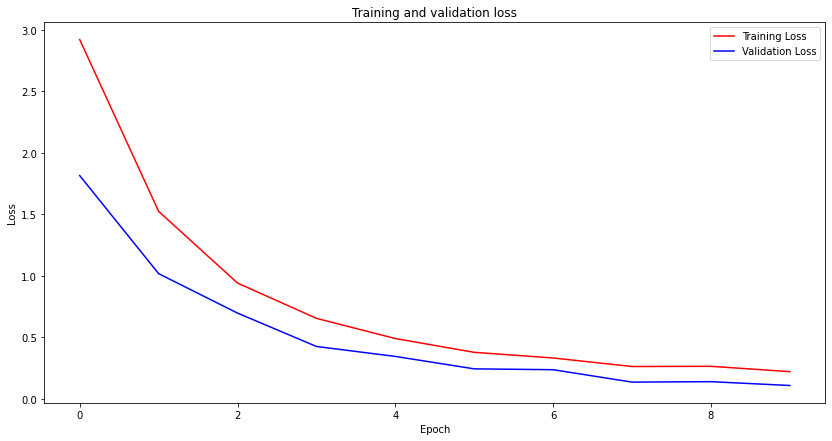

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_3_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 69ms/step - loss: 0.1073 - accuracy: 0.9723
loss : 0.10732541978359222 acc : 0.9723052382469177


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_3_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 68ms/step
              precision    recall  f1-score   support

           A       0.93      0.99      0.96       600
           B       0.96      0.99      0.97       600
           C       1.00      1.00      1.00       600
           D       1.00      1.00      1.00       600
           E       0.99      0.89      0.94       600
           F       1.00      0.99      1.00       600
           G       1.00      0.96      0.98       600
           H       0.96      1.00      0.98       600
           I       1.00      0.99      0.99       602
           J       1.00      1.00      1.00       600
           K       0.99      0.99      0.99       600
           L       1.00      1.00      1.00       600
           M       0.97      0.98      0.97       600
           N       0.95      0.97      0.96       602
           O       1.00      0.96      0.98       600
           P       0.99      0.98      0.99       600
           Q       0.98 

<Figure size 3600x3600 with 0 Axes>

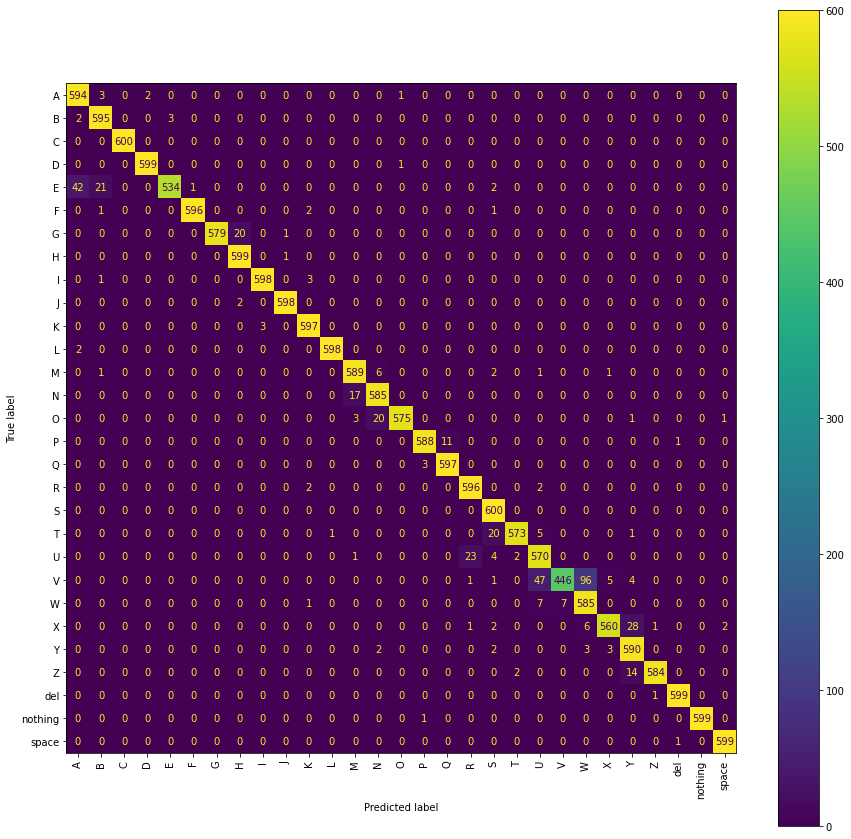

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (6,6)**

In [ ]:
# defining the model
model_4_1l = Sequential()

model_4_1l.add(Conv2D(32, kernel_size=(6,6), input_shape=target_dims))
model_4_1l.add(Activation('relu'))
model_4_1l.add(MaxPooling2D((2, 2)))
model_4_1l.add(Dropout(0.5))

model_4_1l.add(Flatten())
model_4_1l.add(Dropout(0.5))

model_4_1l.add(Dense(128, activation='mish'))

model_4_1l.add(Dense(num_classes, activation='softmax'))

model_4_1l.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 59, 59, 32)        3488      
                                                                 
 activation_7 (Activation)   (None, 59, 59, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 29, 29, 32)        0         
                                                                 
 flatten_5 (Flatten)         (None, 26912)             0         
                                                                 
 dropout_11 (Dropout)        (None, 26912)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_4_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_4_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 88s 92ms/step - loss: 3.1756 - accuracy: 0.1228 - val_loss: 2.4422 - val_accuracy: 0.3108
Epoch 2/10
952/952 [==============================] - 88s 92ms/step - loss: 1.8836 - accuracy: 0.4341 - val_loss: 1.1872 - val_accuracy: 0.6412
Epoch 3/10
952/952 [==============================] - 87s 92ms/step - loss: 1.1490 - accuracy: 0.6351 - val_loss: 0.8372 - val_accuracy: 0.7198
Epoch 4/10
952/952 [==============================] - 88s 92ms/step - loss: 0.8175 - accuracy: 0.7299 - val_loss: 0.5542 - val_accuracy: 0.8343
Epoch 5/10
952/952 [==============================] - 88s 93ms/step - loss: 0.6070 - accuracy: 0.7956 - val_loss: 0.3301 - val_accuracy: 0.9215
Epoch 6/10
952/952 [==============================] - 89s 94ms/step - loss: 0.4790 - accuracy: 0.8376 - val_loss: 0.2846 - val_accuracy: 0.9121
Epoch 7/10
952/952 [==============================] - 89s 93ms/step - loss: 0.3985 - accuracy: 0.8648 - val_loss: 0.1881 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_4_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.175648,0.122829,2.442180,0.310848
1,1.883643,0.434055,1.187205,0.641232
2,1.149019,0.635076,0.837246,0.719835
3,0.817485,0.729865,0.554158,0.834291
4,0.607049,0.795564,0.330130,0.921512
5,0.478974,0.837591,0.284605,0.912089
6,0.398526,0.864793,0.188140,0.939094
7,0.323149,0.889681,0.168473,0.951965
8,0.276108,0.906557,0.199822,0.929671
9,0.247844,0.915520,0.119014,0.961963


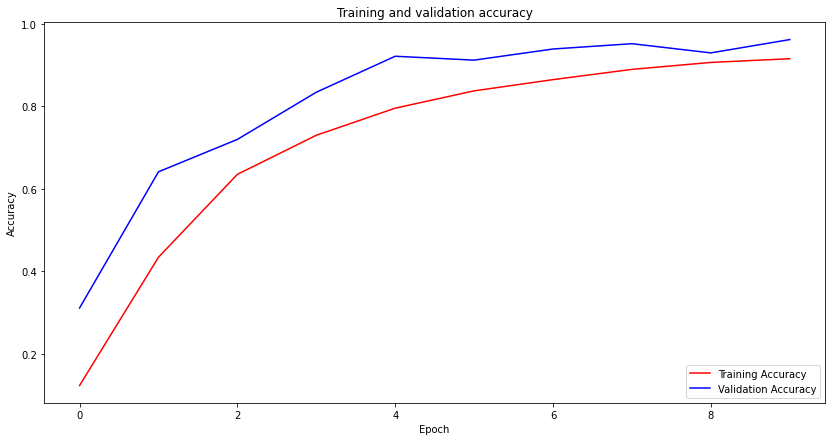

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_4_1l.history.history['accuracy']
val_acc= model_4_1l.history.history['val_accuracy']
loss= model_4_1l.history.history['loss']
val_loss= model_4_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

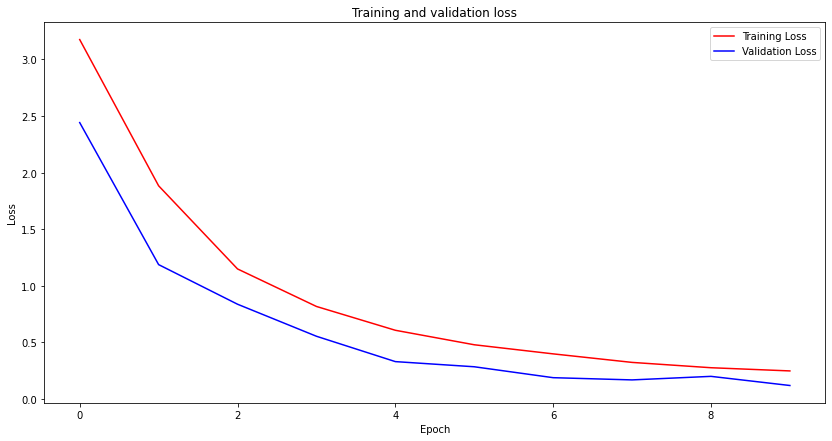

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_4_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 70ms/step - loss: 0.1162 - accuracy: 0.9648
loss : 0.1161845251917839 acc : 0.9648356437683105


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_4_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 70ms/step
              precision    recall  f1-score   support

           A       0.98      0.99      0.99       600
           B       0.98      0.97      0.97       600
           C       1.00      1.00      1.00       600
           D       0.99      1.00      0.99       600
           E       0.96      0.96      0.96       600
           F       1.00      0.99      1.00       600
           G       1.00      0.96      0.98       600
           H       0.97      0.99      0.98       600
           I       0.99      0.99      0.99       602
           J       0.99      1.00      1.00       600
           K       0.99      0.98      0.99       600
           L       1.00      1.00      1.00       600
           M       0.99      0.96      0.97       600
           N       0.98      0.99      0.98       602
           O       0.98      0.99      0.98       600
           P       0.88      0.99      0.93       600
           Q       0.99 

<Figure size 3600x3600 with 0 Axes>

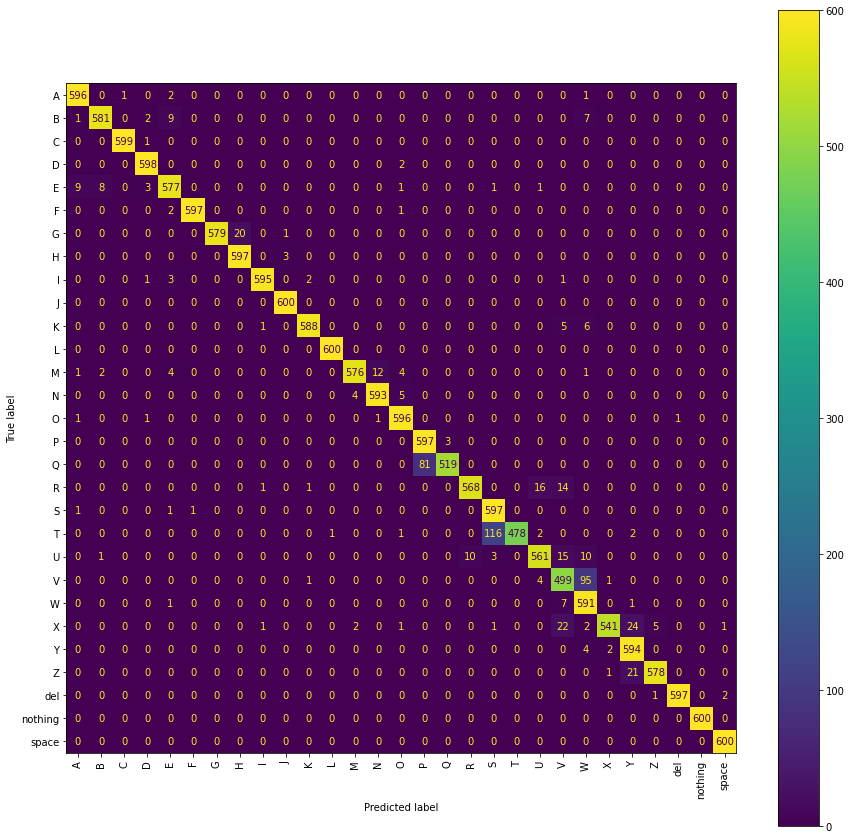

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (8,8)**

In [ ]:
# defining the model
model_5_1l = Sequential()

model_5_1l.add(Conv2D(32, kernel_size=(8,8), input_shape=target_dims))
model_5_1l.add(Activation('relu'))
model_5_1l.add(MaxPooling2D((2, 2)))
model_5_1l.add(Dropout(0.5))

model_5_1l.add(Flatten())
model_5_1l.add(Dropout(0.5))

model_5_1l.add(Dense(128, activation='mish'))

model_5_1l.add(Dense(num_classes, activation='softmax'))

model_5_1l.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 57, 57, 32)        6176      
                                                                 
 activation_8 (Activation)   (None, 57, 57, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_13 (Dropout)        (None, 25088)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_5_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_5_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 90s 94ms/step - loss: 3.4035 - accuracy: 0.0256 - val_loss: 3.3651 - val_accuracy: 0.0449
Epoch 2/10
952/952 [==============================] - 89s 93ms/step - loss: 3.2034 - accuracy: 0.1006 - val_loss: 2.8252 - val_accuracy: 0.2194
Epoch 3/10
952/952 [==============================] - 91s 96ms/step - loss: 2.4480 - accuracy: 0.2894 - val_loss: 1.8345 - val_accuracy: 0.4394
Epoch 4/10
952/952 [==============================] - 93s 98ms/step - loss: 1.7731 - accuracy: 0.4621 - val_loss: 1.2422 - val_accuracy: 0.6423
Epoch 5/10
952/952 [==============================] - 94s 98ms/step - loss: 1.4304 - accuracy: 0.5557 - val_loss: 1.0093 - val_accuracy: 0.6911
Epoch 6/10
952/952 [==============================] - 93s 98ms/step - loss: 1.2335 - accuracy: 0.6106 - val_loss: 0.8413 - val_accuracy: 0.7510
Epoch 7/10
952/952 [==============================] - 93s 98ms/step - loss: 1.0875 - accuracy: 0.6522 - val_loss: 0.6586 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_5_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.403527,0.025577,3.365128,0.044932
1,3.203395,0.100552,2.825228,0.219375
2,2.448048,0.289375,1.834453,0.439439
3,1.773075,0.462094,1.242224,0.642266
4,1.430440,0.555652,1.009256,0.691105
5,1.233460,0.610648,0.841349,0.750977
6,1.087515,0.652182,0.658565,0.806022
7,0.965141,0.689579,0.587472,0.819122
8,0.867339,0.718259,0.518796,0.846127
9,0.771304,0.749401,0.434075,0.869800


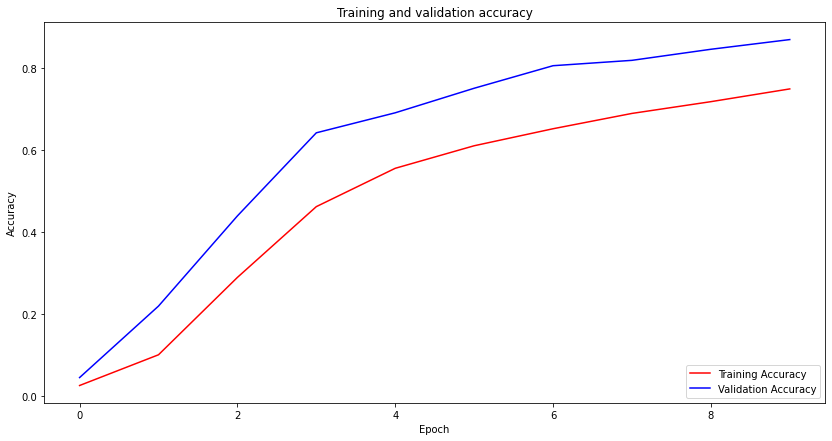

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_5_1l.history.history['accuracy']
val_acc= model_5_1l.history.history['val_accuracy']
loss= model_5_1l.history.history['loss']
val_loss= model_5_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

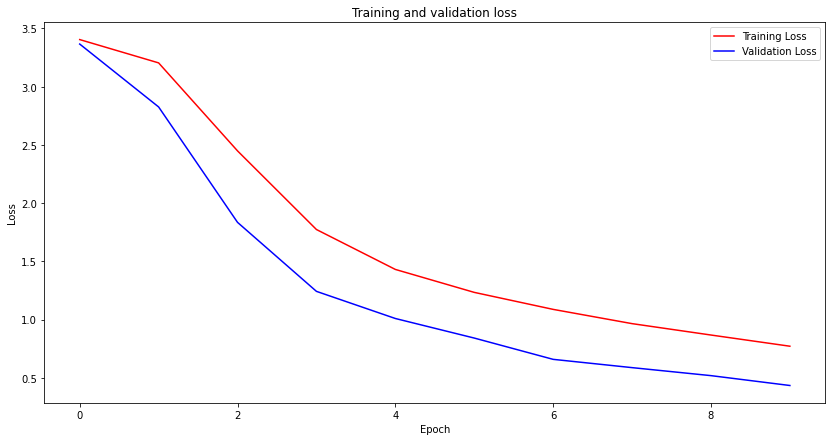

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_5_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 69ms/step - loss: 0.4351 - accuracy: 0.8687
loss : 0.4351043105125427 acc : 0.8686509132385254


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_5_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 69ms/step
              precision    recall  f1-score   support

           A       0.73      0.93      0.81       600
           B       0.82      0.84      0.83       600
           C       0.96      0.98      0.97       600
           D       0.93      0.97      0.95       600
           E       0.94      0.49      0.64       600
           F       0.96      0.94      0.95       600
           G       0.96      0.96      0.96       600
           H       0.96      0.96      0.96       600
           I       0.93      0.92      0.92       602
           J       0.98      0.99      0.99       600
           K       0.93      0.88      0.90       600
           L       0.96      0.95      0.96       600
           M       0.94      0.62      0.75       600
           N       0.84      0.91      0.87       602
           O       0.84      0.92      0.88       600
           P       0.92      0.97      0.94       600
           Q       0.94 

<Figure size 3600x3600 with 0 Axes>

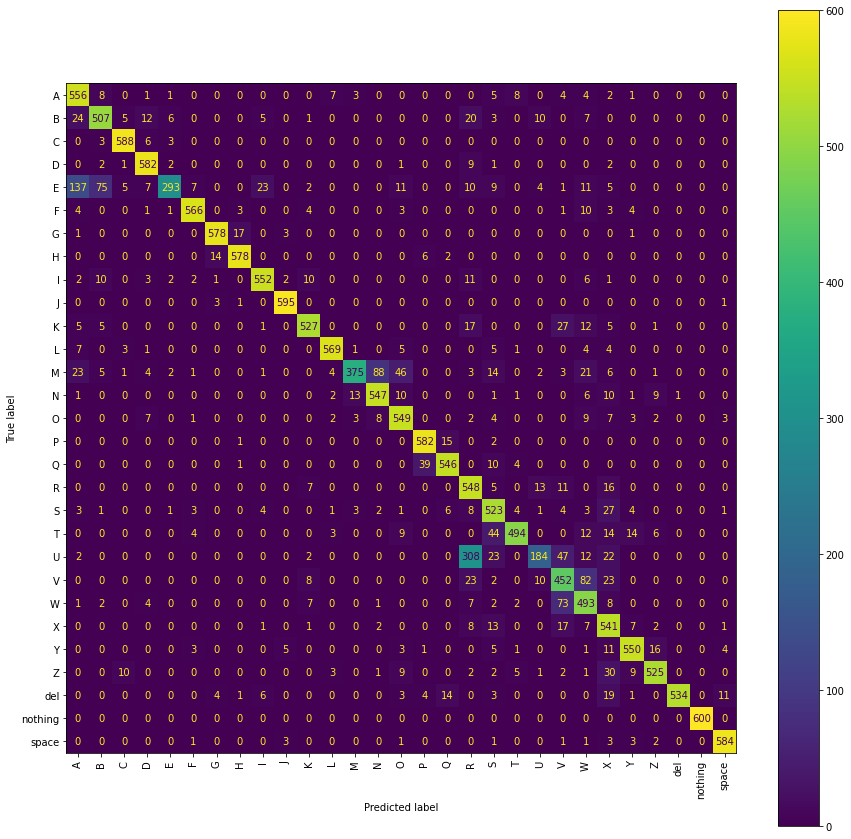

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

## **CNN Models with 2 Convolutional layers, 2 Maxpooling layers and 2 Dropout layers**

#### **Kernel size - (5,5)**

In [ ]:
# defining the model
model_1_2l = Sequential()

model_1_2l.add(Conv2D(32, kernel_size=(5,5), input_shape=target_dims))
model_1_2l.add(Activation('relu'))
model_1_2l.add(MaxPooling2D((2, 2)))
model_1_2l.add(Dropout(0.5))

model_1_2l.add(Conv2D(32, kernel_size=(5,5), input_shape=target_dims))
model_1_2l.add(Activation('relu'))
model_1_2l.add(MaxPooling2D((2, 2)))
model_1_2l.add(Dropout(0.5))

model_1_2l.add(Flatten())
model_1_2l.add(Dropout(0.5))

model_1_2l.add(Dense(128, activation='mish'))

model_1_2l.add(Dense(num_classes, activation='softmax'))

model_1_2l.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 activation_9 (Activation)   (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        25632     
                                                                 
 activation_10 (Activation)  (None, 26, 26, 32)        0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_1_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_1_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 96s 101ms/step - loss: 3.3773 - accuracy: 0.0285 - val_loss: 3.3016 - val_accuracy: 0.0653
Epoch 2/10
952/952 [==============================] - 95s 100ms/step - loss: 3.1087 - accuracy: 0.1201 - val_loss: 2.5294 - val_accuracy: 0.3031
Epoch 3/10
952/952 [==============================] - 96s 101ms/step - loss: 2.1220 - accuracy: 0.3708 - val_loss: 1.2913 - val_accuracy: 0.6530
Epoch 4/10
952/952 [==============================] - 95s 100ms/step - loss: 1.2894 - accuracy: 0.5862 - val_loss: 0.7883 - val_accuracy: 0.7967
Epoch 5/10
952/952 [==============================] - 96s 101ms/step - loss: 0.8873 - accuracy: 0.7096 - val_loss: 0.4937 - val_accuracy: 0.8567
Epoch 6/10
952/952 [==============================] - 96s 101ms/step - loss: 0.6725 - accuracy: 0.7753 - val_loss: 0.3818 - val_accuracy: 0.8924
Epoch 7/10
952/952 [==============================] - 96s 101ms/step - loss: 0.5481 - accuracy: 0.8167 - val_loss: 0.2526 - val_ac

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_1_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.377338,0.028548,3.301594,0.065272
1,3.108678,0.120104,2.529432,0.303149
2,2.122003,0.370752,1.291302,0.652953
3,1.289375,0.586236,0.788288,0.796713
4,0.887347,0.709607,0.493690,0.856700
5,0.672462,0.775257,0.381821,0.892439
6,0.548070,0.816692,0.252578,0.935532
7,0.458972,0.846521,0.212524,0.942542
8,0.399605,0.866270,0.169972,0.955183
9,0.371419,0.876088,0.136073,0.964836


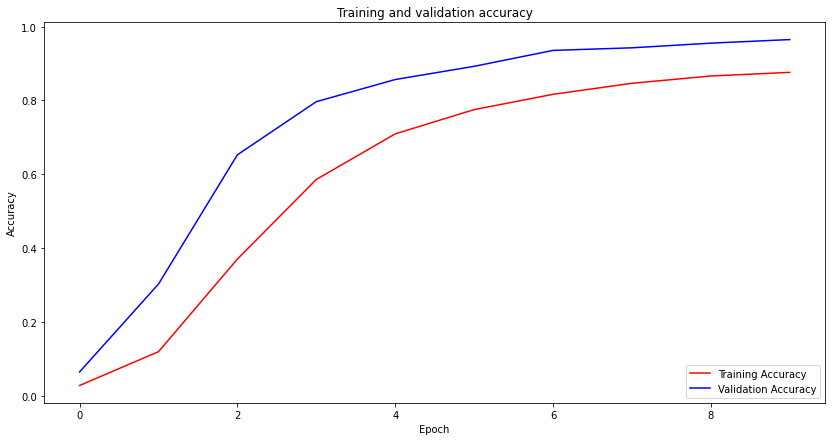

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_1_2l.history.history['accuracy']
val_acc= model_1_2l.history.history['val_accuracy']
loss= model_1_2l.history.history['loss']
val_loss= model_1_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

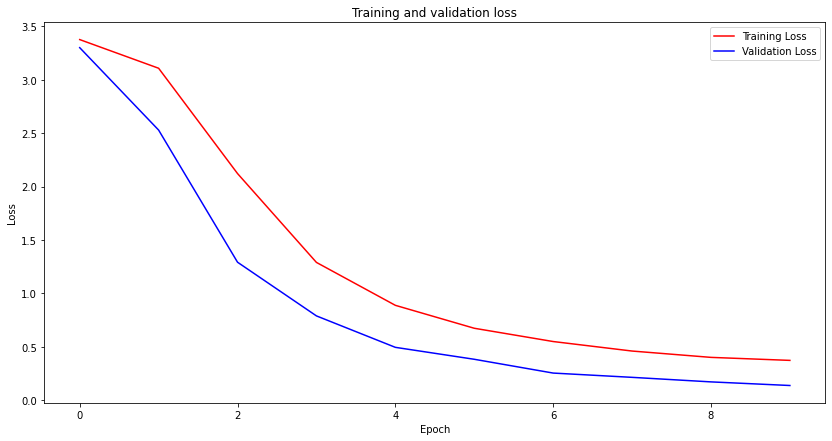

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_1_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 71ms/step - loss: 0.1353 - accuracy: 0.9643
loss : 0.13526782393455505 acc : 0.964318573474884


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_1_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 70ms/step
              precision    recall  f1-score   support

           A       0.95      0.98      0.97       600
           B       0.95      0.98      0.97       600
           C       1.00      1.00      1.00       600
           D       0.99      1.00      0.99       600
           E       0.99      0.88      0.93       600
           F       1.00      0.99      1.00       600
           G       0.98      1.00      0.99       600
           H       0.99      0.98      0.99       600
           I       0.97      0.99      0.98       602
           J       0.99      0.99      0.99       600
           K       0.94      0.98      0.96       600
           L       0.99      1.00      1.00       600
           M       0.97      0.99      0.98       600
           N       0.99      0.96      0.97       602
           O       1.00      0.98      0.99       600
           P       1.00      1.00      1.00       600
           Q       1.00 

<Figure size 3600x3600 with 0 Axes>

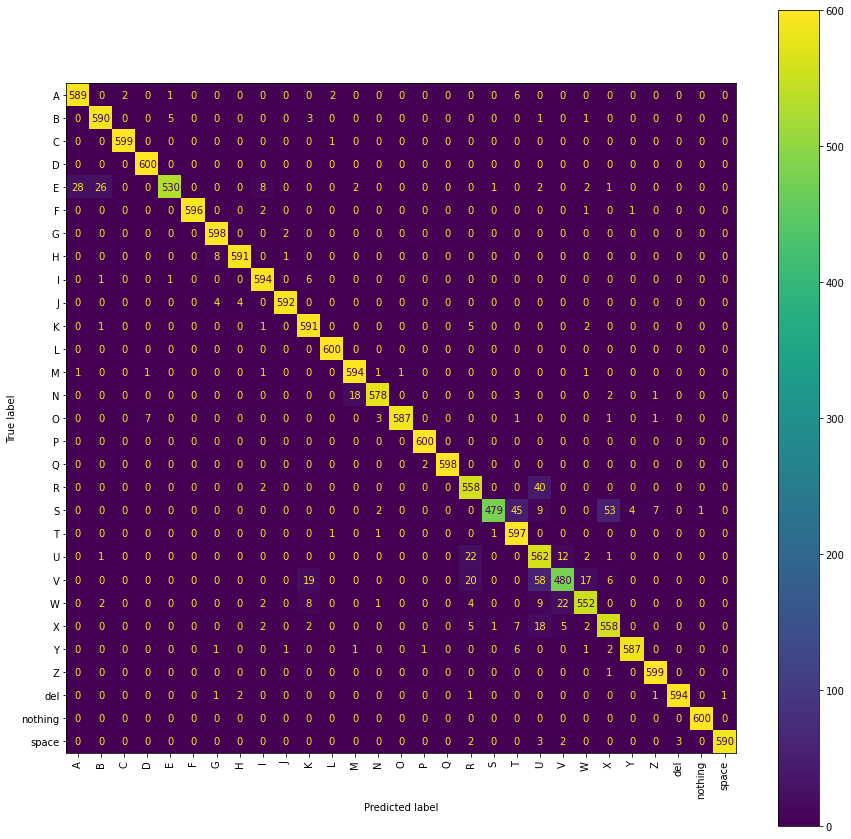

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (7,7)**

In [ ]:
# defining the model
model_2_2l = Sequential()

model_2_2l.add(Conv2D(32, kernel_size=(7,7), input_shape=target_dims))
model_2_2l.add(Activation('relu'))
model_2_2l.add(MaxPooling2D((2, 2)))
model_2_2l.add(Dropout(0.5))

model_2_2l.add(Conv2D(32, kernel_size=(7,7), input_shape=target_dims))
model_2_2l.add(Activation('relu'))
model_2_2l.add(MaxPooling2D((2, 2)))
model_2_2l.add(Dropout(0.5))

model_2_2l.add(Flatten())
model_2_2l.add(Dropout(0.5))

model_2_2l.add(Dense(128, activation='mish'))

model_2_2l.add(Dense(num_classes, activation='softmax'))

model_2_2l.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 58, 58, 32)        4736      
                                                                 
 activation_11 (Activation)  (None, 58, 58, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_17 (Dropout)        (None, 29, 29, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 23, 23, 32)        50208     
                                                                 
 activation_12 (Activation)  (None, 23, 23, 32)        0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_2_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_2_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 106s 111ms/step - loss: 3.3774 - accuracy: 0.0222 - val_loss: 3.3676 - val_accuracy: 0.0345
Epoch 2/10
952/952 [==============================] - 105s 110ms/step - loss: 3.3736 - accuracy: 0.0260 - val_loss: 3.3675 - val_accuracy: 0.0345
Epoch 3/10
952/952 [==============================] - 105s 110ms/step - loss: 3.3789 - accuracy: 0.0221 - val_loss: 3.3678 - val_accuracy: 0.0345
Epoch 4/10
952/952 [==============================] - 105s 110ms/step - loss: 3.3732 - accuracy: 0.0269 - val_loss: 3.3677 - val_accuracy: 0.0345
Epoch 5/10
952/952 [==============================] - 105s 111ms/step - loss: 3.3732 - accuracy: 0.0255 - val_loss: 3.3674 - val_accuracy: 0.0345
Epoch 6/10
952/952 [==============================] - 105s 111ms/step - loss: 3.3724 - accuracy: 0.0252 - val_loss: 3.3677 - val_accuracy: 0.0345
Epoch 7/10
952/952 [==============================] - 105s 111ms/step - loss: 3.3724 - accuracy: 0.0282 - val_loss: 3.3680 -

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_2_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.377418,0.022179,3.367599,0.034475
1,3.373584,0.026020,3.367470,0.034475
2,3.378904,0.022146,3.367787,0.034475
3,3.373163,0.026858,3.367658,0.034475
4,3.373218,0.025511,3.367387,0.034475
5,3.372429,0.025216,3.367705,0.034475
6,3.372424,0.028204,3.368037,0.034475
7,3.372452,0.025216,3.368003,0.034475
8,3.373258,0.028368,3.367402,0.034475
9,3.372756,0.023919,3.367435,0.034475


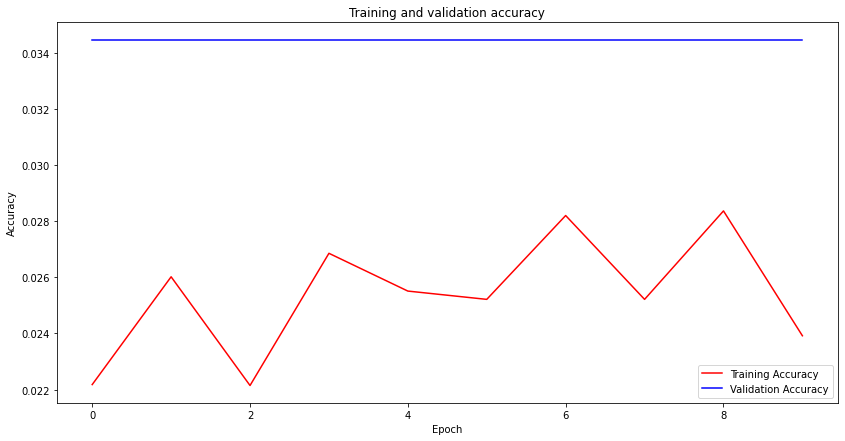

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_2_2l.history.history['accuracy']
val_acc= model_2_2l.history.history['val_accuracy']
loss= model_2_2l.history.history['loss']
val_loss= model_2_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

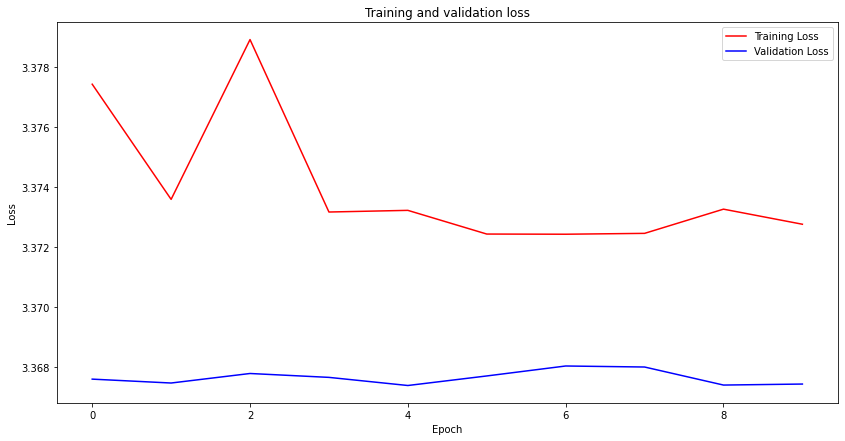

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_2_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 20s 72ms/step - loss: 3.3674 - accuracy: 0.0345
loss : 3.367429256439209 acc : 0.03447483479976654


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_2_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 71ms/step
              precision    recall  f1-score   support

           A       0.03      1.00      0.07       600
           B       0.00      0.00      0.00       600
           C       0.00      0.00      0.00       600
           D       0.00      0.00      0.00       600
           E       0.00      0.00      0.00       600
           F       0.00      0.00      0.00       600
           G       0.00      0.00      0.00       600
           H       0.00      0.00      0.00       600
           I       0.00      0.00      0.00       602
           J       0.00      0.00      0.00       600
           K       0.00      0.00      0.00       600
           L       0.00      0.00      0.00       600
           M       0.00      0.00      0.00       600
           N       0.00      0.00      0.00       602
           O       0.00      0.00      0.00       600
           P       0.00      0.00      0.00       600
           Q       0.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 3600x3600 with 0 Axes>

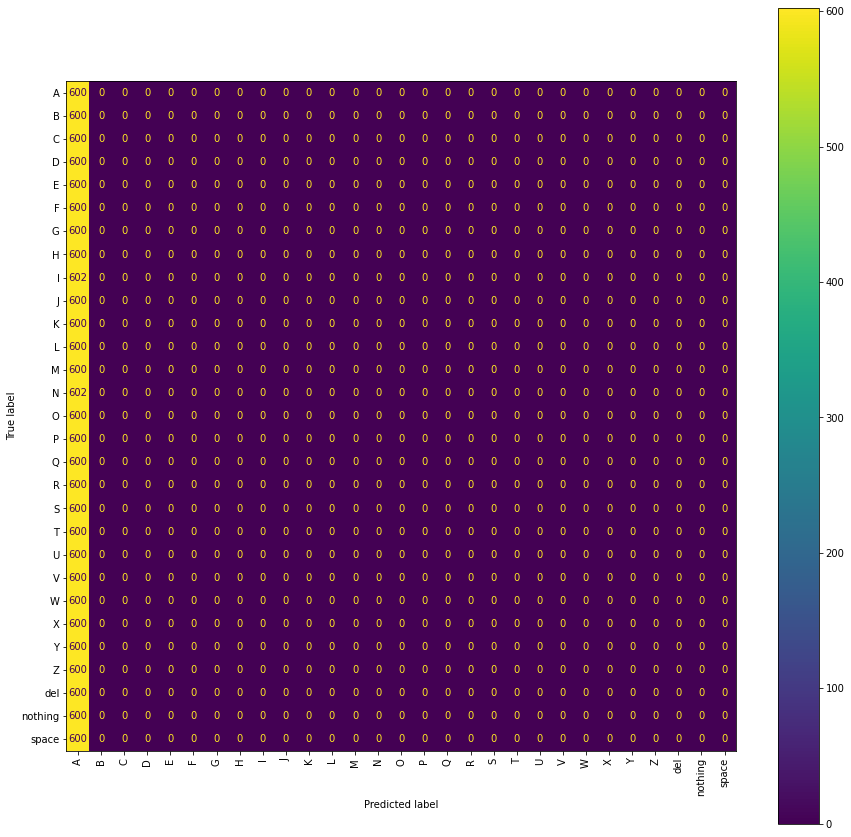

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (4,4)**

In [ ]:
# defining the model
model_3_2l = Sequential()

model_3_2l.add(Conv2D(32, kernel_size=(4,4), input_shape=target_dims))
model_3_2l.add(Activation('relu'))
model_3_2l.add(MaxPooling2D((2, 2)))
model_3_2l.add(Dropout(0.5))

model_3_2l.add(Conv2D(32, kernel_size=(4,4), input_shape=target_dims))
model_3_2l.add(Activation('relu'))
model_3_2l.add(MaxPooling2D((2, 2)))
model_3_2l.add(Dropout(0.5))

model_3_2l.add(Flatten())
model_3_2l.add(Dropout(0.5))

model_3_2l.add(Dense(128, activation='mish'))

model_3_2l.add(Dense(num_classes, activation='softmax'))

model_3_2l.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 61, 61, 32)        1568      
                                                                 
 activation_13 (Activation)  (None, 61, 61, 32)        0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 27, 27, 32)        16416     
                                                                 
 activation_14 (Activation)  (None, 27, 27, 32)        0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_3_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_3_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 94s 98ms/step - loss: 3.3940 - accuracy: 0.0237 - val_loss: 3.3675 - val_accuracy: 0.0346
Epoch 2/10
952/952 [==============================] - 92s 97ms/step - loss: 3.3701 - accuracy: 0.0344 - val_loss: 3.2857 - val_accuracy: 0.0937
Epoch 3/10
952/952 [==============================] - 92s 97ms/step - loss: 2.9743 - accuracy: 0.1632 - val_loss: 2.1796 - val_accuracy: 0.3800
Epoch 4/10
952/952 [==============================] - 92s 97ms/step - loss: 1.8698 - accuracy: 0.4264 - val_loss: 1.1673 - val_accuracy: 0.6883
Epoch 5/10
952/952 [==============================] - 92s 97ms/step - loss: 1.2253 - accuracy: 0.6082 - val_loss: 0.6902 - val_accuracy: 0.8197
Epoch 6/10
952/952 [==============================] - 92s 97ms/step - loss: 0.8787 - accuracy: 0.7117 - val_loss: 0.4242 - val_accuracy: 0.9036
Epoch 7/10
952/952 [==============================] - 92s 96ms/step - loss: 0.6903 - accuracy: 0.7696 - val_loss: 0.3392 - val_accuracy:

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_3_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.394035,0.023738,3.367484,0.034590
1,3.370114,0.034360,3.285681,0.093657
2,2.974270,0.163214,2.179622,0.380028
3,1.869763,0.426372,1.167336,0.688348
4,1.225255,0.608235,0.690178,0.819697
5,0.878661,0.711708,0.424153,0.903585
6,0.690325,0.769560,0.339221,0.910480
7,0.567482,0.810585,0.263614,0.931050
8,0.476140,0.840382,0.218803,0.940129
9,0.425975,0.856847,0.225713,0.926109


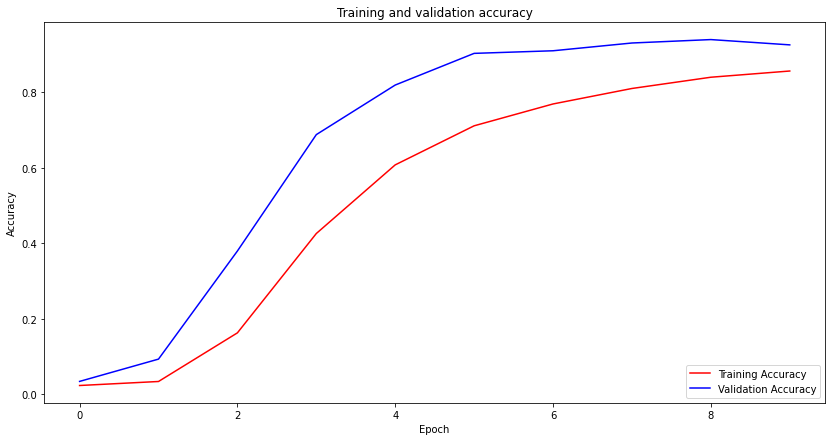

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_3_2l.history.history['accuracy']
val_acc= model_3_2l.history.history['val_accuracy']
loss= model_3_2l.history.history['loss']
val_loss= model_3_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

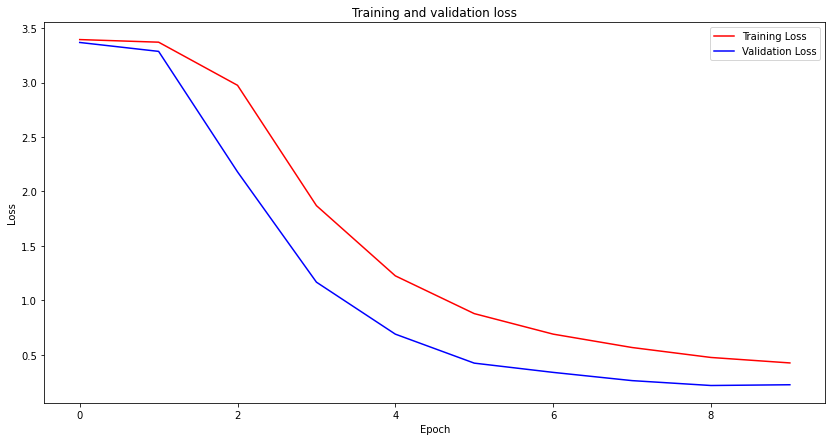

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_3_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 19s 70ms/step - loss: 0.2242 - accuracy: 0.9274
loss : 0.22421438992023468 acc : 0.9273729920387268


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_3_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 70ms/step
              precision    recall  f1-score   support

           A       0.96      0.96      0.96       600
           B       0.98      0.96      0.97       600
           C       1.00      1.00      1.00       600
           D       1.00      0.99      0.99       600
           E       0.89      0.98      0.93       600
           F       1.00      0.99      0.99       600
           G       1.00      0.90      0.94       600
           H       0.89      1.00      0.94       600
           I       0.99      0.96      0.98       602
           J       1.00      0.98      0.99       600
           K       0.98      0.89      0.93       600
           L       0.99      1.00      1.00       600
           M       0.92      0.98      0.95       600
           N       0.99      0.93      0.96       602
           O       0.99      0.98      0.98       600
           P       1.00      0.94      0.97       600
           Q       0.96 

<Figure size 3600x3600 with 0 Axes>

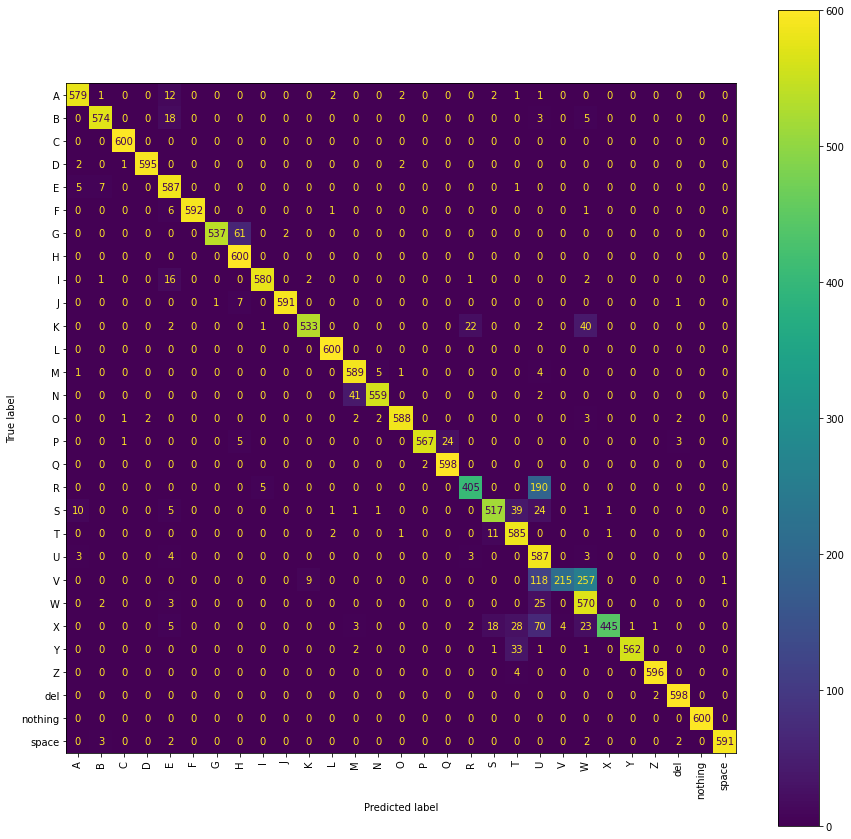

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (6,6)**

In [ ]:
# defining the model
model_4_2l = Sequential()

model_4_2l.add(Conv2D(32, kernel_size=(6,6), input_shape=target_dims))
model_4_2l.add(Activation('relu'))
model_4_2l.add(MaxPooling2D((2, 2)))
model_4_2l.add(Dropout(0.5))

model_4_2l.add(Conv2D(32, kernel_size=(6,6), input_shape=target_dims))
model_4_2l.add(Activation('relu'))
model_4_2l.add(MaxPooling2D((2, 2)))
model_4_2l.add(Dropout(0.5))

model_4_2l.add(Flatten())
model_4_2l.add(Dropout(0.5))

model_4_2l.add(Dense(128, activation='mish'))

model_4_2l.add(Dense(num_classes, activation='softmax'))

model_4_2l.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 59, 59, 32)        3488      
                                                                 
 activation_15 (Activation)  (None, 59, 59, 32)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 29, 29, 32)       0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 29, 29, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        36896     
                                                                 
 activation_16 (Activation)  (None, 24, 24, 32)        0         
                                                     

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_4_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_4_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 100s 105ms/step - loss: 3.3851 - accuracy: 0.0251 - val_loss: 3.3677 - val_accuracy: 0.0345
Epoch 2/10
952/952 [==============================] - 99s 104ms/step - loss: 3.3562 - accuracy: 0.0307 - val_loss: 3.2127 - val_accuracy: 0.0970
Epoch 3/10
952/952 [==============================] - 98s 103ms/step - loss: 2.7001 - accuracy: 0.2139 - val_loss: 2.1592 - val_accuracy: 0.3754
Epoch 4/10
952/952 [==============================] - 98s 103ms/step - loss: 1.8791 - accuracy: 0.4155 - val_loss: 1.5472 - val_accuracy: 0.5302
Epoch 5/10
952/952 [==============================] - 98s 103ms/step - loss: 1.4063 - accuracy: 0.5518 - val_loss: 1.1359 - val_accuracy: 0.7082
Epoch 6/10
952/952 [==============================] - 97s 102ms/step - loss: 1.1002 - accuracy: 0.6438 - val_loss: 0.9879 - val_accuracy: 0.7382
Epoch 7/10
952/952 [==============================] - 98s 103ms/step - loss: 0.9362 - accuracy: 0.6927 - val_loss: 0.8358 - val_a

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_4_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.385067,0.025101,3.367678,0.034475
1,3.356243,0.030732,3.212724,0.096989
2,2.700102,0.213925,2.159154,0.375431
3,1.879146,0.415455,1.547178,0.530223
4,1.406324,0.551762,1.135942,0.708228
5,1.100219,0.643776,0.987892,0.738221
6,0.936159,0.692714,0.835814,0.772121
7,0.797290,0.737187,0.734517,0.821765
8,0.715693,0.761615,0.655866,0.839347
9,0.655770,0.780806,0.618322,0.845438


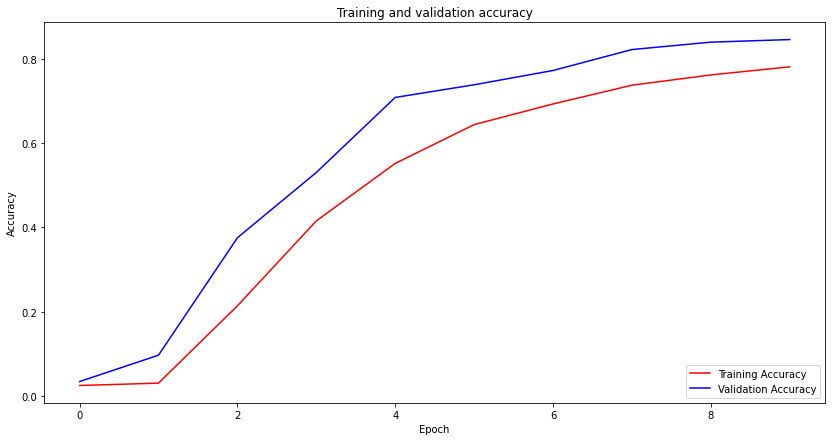

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_4_2l.history.history['accuracy']
val_acc= model_4_2l.history.history['val_accuracy']
loss= model_4_2l.history.history['loss']
val_loss= model_4_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

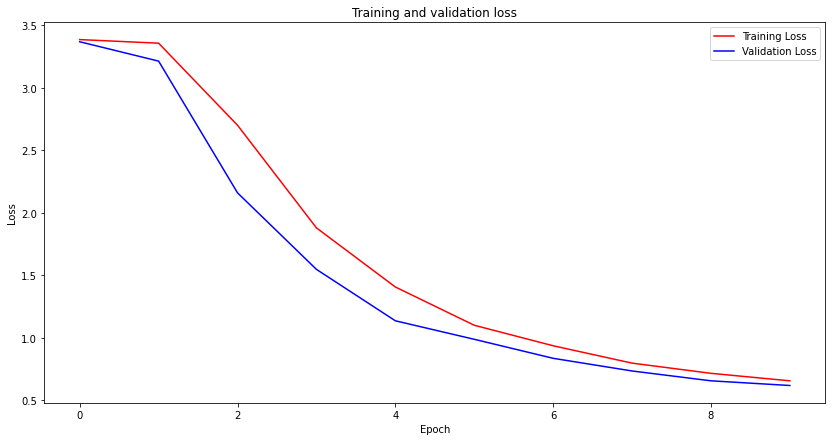

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_4_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 20s 72ms/step - loss: 0.6137 - accuracy: 0.8497
loss : 0.6136540174484253 acc : 0.8497471809387207


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_4_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 19s 71ms/step
              precision    recall  f1-score   support

           A       0.90      0.92      0.91       600
           B       0.85      0.93      0.89       600
           C       1.00      1.00      1.00       600
           D       0.96      0.98      0.97       600
           E       0.88      0.84      0.86       600
           F       1.00      0.95      0.98       600
           G       0.94      0.98      0.96       600
           H       0.98      0.95      0.96       600
           I       0.86      0.96      0.91       602
           J       0.90      0.99      0.95       600
           K       0.80      0.96      0.87       600
           L       0.97      0.99      0.98       600
           M       0.97      0.56      0.71       600
           N       0.62      0.96      0.75       602
           O       0.85      0.83      0.84       600
           P       0.78      0.83      0.81       600
           Q       0.55 

<Figure size 3600x3600 with 0 Axes>

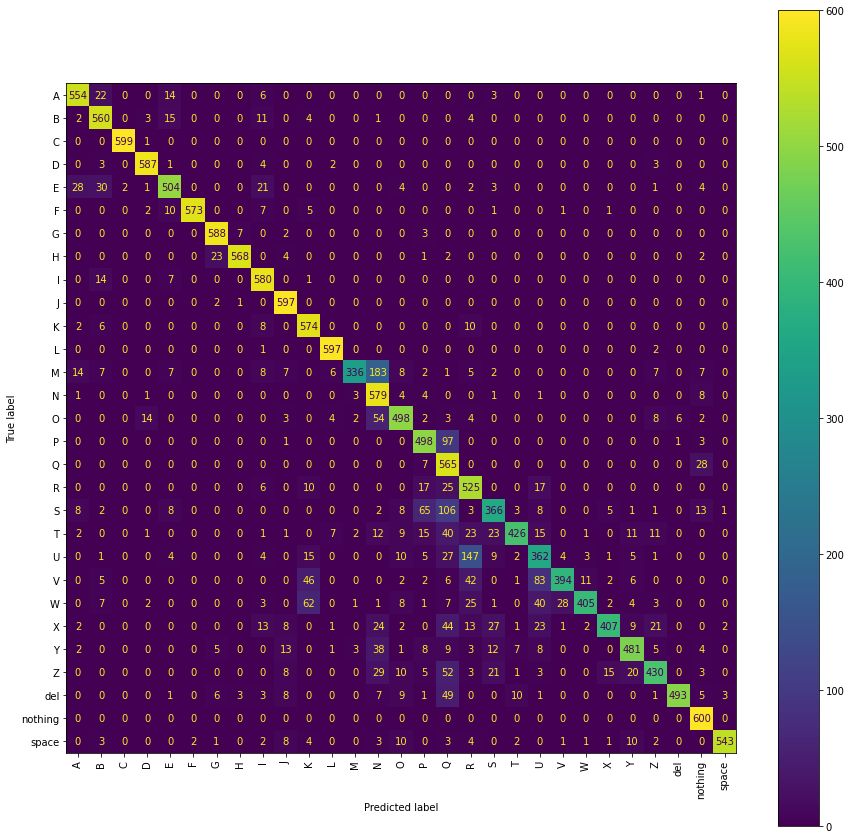

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (8,8)**

In [ ]:
# defining the model
model_5_2l = Sequential()

model_5_2l.add(Conv2D(32, kernel_size=(8,8), input_shape=target_dims))
model_5_2l.add(Activation('relu'))
model_5_2l.add(MaxPooling2D((2, 2)))
model_5_2l.add(Dropout(0.5))

model_5_2l.add(Conv2D(32, kernel_size=(8,8), input_shape=target_dims))
model_5_2l.add(Activation('relu'))
model_5_2l.add(MaxPooling2D((2, 2)))
model_5_2l.add(Dropout(0.5))

model_5_2l.add(Flatten())
model_5_2l.add(Dropout(0.5))

model_5_2l.add(Dense(128, activation='mish'))

model_5_2l.add(Dense(num_classes, activation='softmax'))

model_5_2l.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 57, 57, 32)        6176      
                                                                 
 activation_17 (Activation)  (None, 57, 57, 32)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 21, 21, 32)        65568     
                                                                 
 activation_18 (Activation)  (None, 21, 21, 32)        0         
                                                     

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_5_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_5_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 115s 120ms/step - loss: 3.2734 - accuracy: 0.0652 - val_loss: 3.0243 - val_accuracy: 0.1394
Epoch 2/10
952/952 [==============================] - 112s 118ms/step - loss: 2.5881 - accuracy: 0.2479 - val_loss: 2.0005 - val_accuracy: 0.3985
Epoch 3/10
952/952 [==============================] - 113s 118ms/step - loss: 1.7889 - accuracy: 0.4485 - val_loss: 1.3486 - val_accuracy: 0.6004
Epoch 4/10
952/952 [==============================] - 112s 117ms/step - loss: 1.3584 - accuracy: 0.5713 - val_loss: 0.9732 - val_accuracy: 0.7335
Epoch 5/10
952/952 [==============================] - 112s 118ms/step - loss: 1.1185 - accuracy: 0.6451 - val_loss: 0.8066 - val_accuracy: 0.7771
Epoch 6/10
952/952 [==============================] - 113s 118ms/step - loss: 0.9751 - accuracy: 0.6855 - val_loss: 0.6929 - val_accuracy: 0.7909
Epoch 7/10
952/952 [==============================] - 118s 124ms/step - loss: 0.8761 - accuracy: 0.7152 - val_loss: 0.6444 -

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_5_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,3.273426,0.065207,3.024284,0.139393
1,2.588119,0.247923,2.000534,0.398529
2,1.788917,0.448468,1.348646,0.600437
3,1.358362,0.571330,0.973186,0.733510
4,1.118491,0.645090,0.806644,0.777063
5,0.975103,0.685458,0.692911,0.790853
6,0.876082,0.715172,0.644353,0.823374
7,0.790786,0.740798,0.594291,0.831303
8,0.748536,0.753095,0.524404,0.866582
9,0.674006,0.779525,0.458903,0.876465


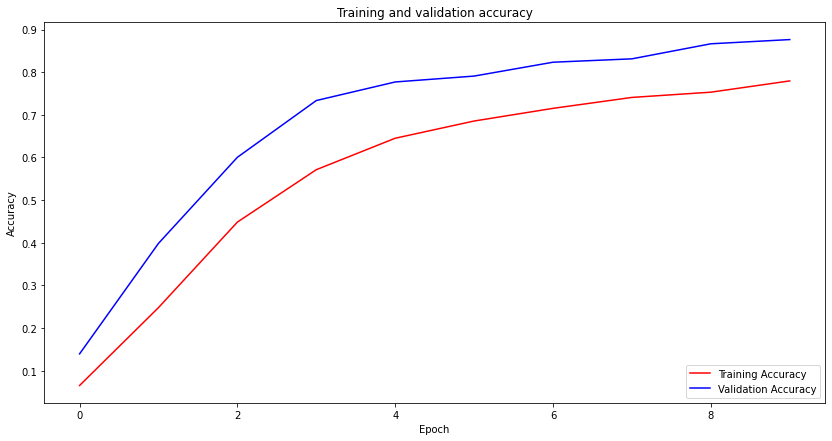

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_5_2l.history.history['accuracy']
val_acc= model_5_2l.history.history['val_accuracy']
loss= model_5_2l.history.history['loss']
val_loss= model_5_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

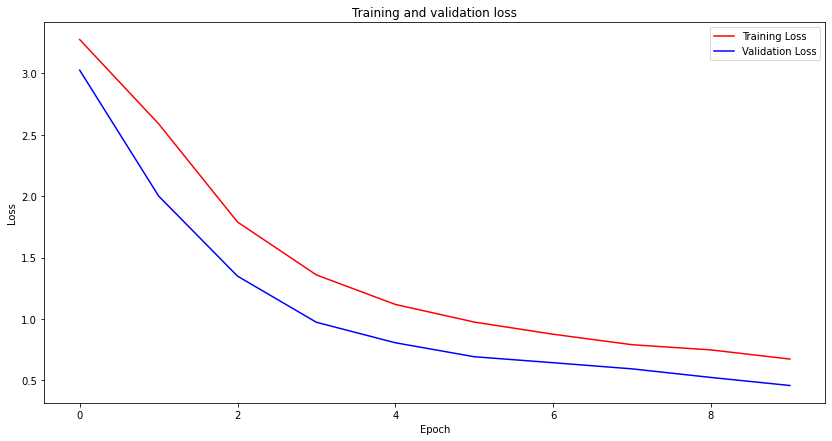

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_5_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 20s 73ms/step - loss: 0.4454 - accuracy: 0.8831
loss : 0.44540590047836304 acc : 0.8830728530883789


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_5_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 20s 72ms/step
              precision    recall  f1-score   support

           A       0.82      0.97      0.89       600
           B       0.81      0.97      0.88       600
           C       1.00      0.98      0.99       600
           D       0.98      0.94      0.96       600
           E       0.99      0.73      0.84       600
           F       1.00      0.96      0.98       600
           G       0.98      0.94      0.96       600
           H       0.96      0.98      0.97       600
           I       0.94      0.94      0.94       602
           J       0.95      0.99      0.97       600
           K       0.85      0.93      0.89       600
           L       1.00      0.98      0.99       600
           M       0.82      0.83      0.83       600
           N       0.71      0.94      0.81       602
           O       0.97      0.86      0.91       600
           P       0.99      0.86      0.92       600
           Q       0.87 

<Figure size 3600x3600 with 0 Axes>

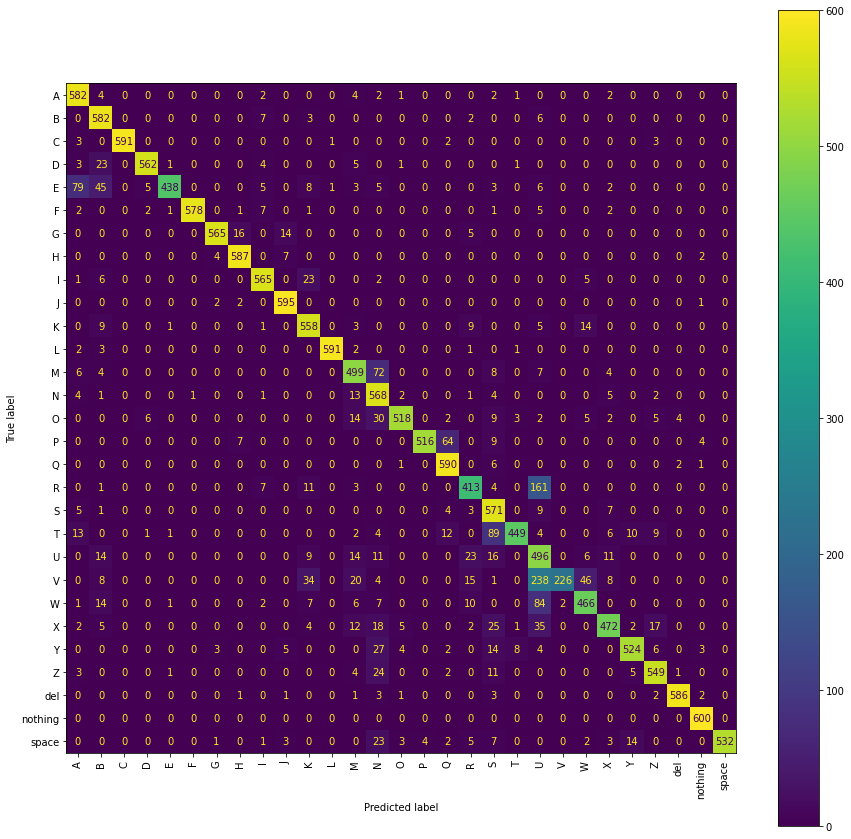

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')